# Controlador de vuelo para vehículos aéreos no tripulados multi-rotor basado en técnicas de aprendizaje profundo

## Entrenamiento Red LSTM

### Javier Cárdenas - Uriel Carrero

## 1. Descripción del Dataset

#### Importar Librerías

In [1]:
import os
import sys
import random
import csv

import matplotlib.pyplot as plt     # Gráficos
import pandas as pd
pd.set_option('display.max_columns', None) #Para mostrar todas las columnas

import numpy as np                  # Cómputo Numérico
print(np.__version__)
seed = 5
np.random.seed(seed)
np.seterr(divide = 'ignore')

1.19.5


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
import tensorflow as tf
import keras as kr
from tensorflow.keras import models, layers
print(tf.__version__)
print(kr.__version__)
#assert (tf.__version__=='2.4.1'), 'Versión incorrecta de Tensorflow, por favor instale 2.4.1'
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from IPython.display import clear_output

#import multiprocessing
#THREADS = multiprocessing.cpu_count()

Using TensorFlow backend.


2.1.0
2.3.1


In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

gpus = tf.config.list_physical_devices('GPU')
config = ConfigProto()
if gpus:
    try:
        config.gpu_options.allow_growth = True
        tf.compat.v1.enable_eager_execution()

        os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
session = InteractiveSession(config=config)

1 Physical GPUs, 1 Logical GPUs


In [4]:
import gc #garbage collector
import gc; gc.enable()

## Cargar Datos

### Leemos el Dataset

In [5]:
root = '../logs/Datasets/'
#dataset_name = 'DatasetPSO_XYZ'
dataset_name = 'DatasetXYZYaw_2022V2'
#dataset_name = 'Dataset_PSO_2022V1'
rootdir = root+dataset_name
ext_csv = True
if not os.path.exists(rootdir):
    print(f"{rootdir} not exist")
if ext_csv:
    # Colocar la extensión csv porque ajá
    for filename in os.listdir(rootdir):
        if not filename.endswith(".csv"):
            os.rename(f'{rootdir}/{filename}',f'{dataset_name}/{filename+".csv"}')

In [6]:
df = pd.read_csv(os.path.join(rootdir, random.choice(os.listdir(rootdir))))
delete_list =['Time', 'Bat_V','Bat_Percentage','P_r', 'Q_r', 'R_r', 'Flag_Pitch_Roll', 'Gyro P', 'Gyro Q', 'Gyro R','Ac_Dx', 'Ac_Dy', 'Ac_Dz','Sonar Altitud','Pressure Altitud', 'Acceleracion P', 'Acceleracion Q', 'Acceleracion R']
df_list = df.columns.to_list()
rpm_list = [i for i in df_list if ("Motor" in i)]
states_list = [i for i in df_list if not ((i in delete_list) or (i in rpm_list))]
print(states_list)

['X', 'Y', 'Z', 'Yaw', 'Roll', 'Pitch', 'Dx', 'Dy', 'Dz', 'P', 'Q', 'R', 'X_r', 'Y_r', 'Z_r', 'Yaw_r', 'Pitch_r', 'Roll_r', 'Dx_r', 'Dy_r', 'Dz_r', 'Acceleracion X', 'Acceleracion Y', 'Acceleracion Z']


In [7]:
df_desc = []
for filename in os.listdir(rootdir):
    if not filename.endswith(".csv"):
        continue
    df = pd.read_csv(os.path.join(rootdir, filename))
    df =  df.drop(delete_list, axis=1)
    df_desc.append(df)
df_desc = pd.concat(df_desc)
df_desc = df_desc.describe()

In [8]:
dataset = []
for filename in os.listdir(rootdir):
    if not filename.endswith(".csv"):
        continue
        
    df = pd.read_csv(os.path.join(rootdir, filename))
    df =  df.drop(delete_list, axis=1)
    x = df.drop(rpm_list, axis=1)
    y = df.drop(states_list, axis=1)
    dataset.append([x, y])

df = None
x = None
y= None

#### Descripton del dataset 

In [9]:
df_desc.to_csv('data_description.csv', index=False)
df_desc

,X,Y,Z,Yaw,Roll,Pitch,Dx,Dy,Dz,P,Q,R,Motor1,Motor2,Motor3,Motor4,X_r,Y_r,Z_r,Yaw_r,Pitch_r,Roll_r,Dx_r,Dy_r,Dz_r,Acceleracion X,Acceleracion Y,Acceleracion Z
count,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06,3.859368e+06
mean,-2.148062e+00,8.581393e-01,-1.361919e+00,6.941571e-02,4.212177e-03,-1.258425e-03,-6.380254e-02,4.722424e-02,-4.483362e-04,4.304693e-05,4.907894e-04,8.615122e-04,2.375205e+02,-2.369294e+02,2.371031e+02,-2.376529e+02,-4.423323e-01,8.020333e-02,-1.339738e+00,6.943904e-02,5.413407e-04,5.413407e-04,-4.827215e-03,-3.041949e-04,-1.147789e-02,-1.705777e-03,2.004448e-03,-4.806519e-05
std,1.245948e+01,1.280665e+01,3.523353e-01,1.449267e+00,9.329679e-02,1.070563e-01,5.772355e-01,5.947505e-01,4.883165e-01,4.344218e-01,1.903108e-01,3.530311e-01,6.179896e+01,6.200034e+01,6.209949e+01,6.201273e+01,1.839267e+00,2.001953e+00,3.267278e-01,1.455933e+00,9.463459e-03,9.463459e-03,2.486848e+00,2.673742e+00,3.156394e+00,1.823827e+00,1.937495e+00,1.819518e+00
min,-1.910231e+02,-5.546263e+01,-3.360997e+00,-5.698977e+00,-1.231822e+00,-1.230343e+00,-9.405467e+00,-8.219940e+00,-4.671090e+00,-8.805186e+00,-6.302951e+00,-5.970769e+00,1.000000e+01,-5.000000e+02,1.000000e+01,-5.000000e+02,-5.000000e+00,-4.900000e+00,-2.700000e+00,-5.698900e+00,-3.175523e-01,-3.175523e-01,-1.000000e+03,-9.800000e+02,-3.400000e+02,-1.250098e+02,-1.253153e+02,-1.144005e+02
25%,-1.141038e+00,-8.488176e-01,-1.589636e+00,-6.071872e-05,-8.617007e-04,-7.853758e-04,-4.524640e-03,-3.553482e-03,-1.090286e-02,-4.570262e-03,-2.357028e-03,-1.192331e-03,2.352098e+02,-2.382692e+02,2.348473e+02,-2.382181e+02,-1.060000e+00,-8.200000e-01,-1.587327e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.699710e-02,-7.660736e-02,-1.433379e-01
50%,-2.475608e-01,-1.067103e-01,-1.307021e+00,1.298457e-06,9.695101e-05,1.268892e-04,0.000000e+00,0.000000e+00,1.731190e-04,-6.421081e-07,4.002890e-06,-1.370747e-05,2.366609e+02,-2.365851e+02,2.364810e+02,-2.365589e+02,-2.400000e-01,-1.000000e-01,-1.300000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.493662e-05,2.143905e-04,-3.264192e-03
75%,3.669192e-01,6.018744e-01,-1.101987e+00,2.255217e-04,1.568906e-03,2.024486e-03,3.024116e-03,4.013675e-03,1.086785e-02,4.579417e-03,2.386491e-03,1.178744e-03,2.385271e+02,-2.350571e+02,2.380607e+02,-2.350024e+02,3.900000e-01,6.000000e-01,-1.100000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.629875e-02,7.984044e-02,1.356349e-01
max,4.092953e+01,1.973594e+02,7.122186e-05,5.625904e+00,1.215662e+00,1.150908e+00,1.108913e+01,8.267406e+00,4.484425e+00,9.052526e+00,6.135386e+00,6.021672e+00,5.000000e+02,-1.000000e+01,5.000000e+02,-1.000000e+01,4.700000e+00,4.900000e+00,0.000000e+00,5.621700e+00,3.396701e-01,3.396701e-01,9.399999e+02,9.800000e+02,1.999644e+02,1.265200e+02,1.254210e+02,1.244594e+02


In [10]:
f_min = open ('min.txt','w')
f_max = open ('max.txt','w')
i=1
for i,term in enumerate(states_list):
    f_min.write(str(df_desc[term]["min"]))
    f_min.write("\n")
    f_max.write(str(df_desc[term]["max"]))
    f_max.write("\n")
f_min.close()
f_max.close()

### Diccionario Salidas

In [11]:
f_act = open ('norm_act.txt','w')

for term in rpm_list:
    f_act.write(str(df_desc[term]["min"]))
    f_act.write("\n")
    f_act.write(str(df_desc[term]["max"]))
    f_act.write("\n")
f_act.close()

Conteo de longitud de trayectorias

{10401: 1, 10001: 1, 10601: 2, 9401: 2, 12201: 1, 8201: 2, 11001: 1, 7801: 1, 7401: 1, 24001: 156}


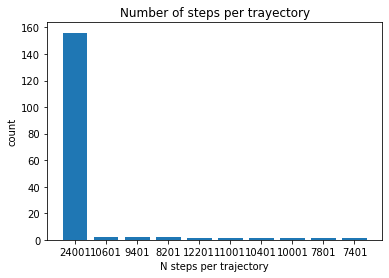

In [12]:
class Counter:
    def __init__(self):
        self.dict = {}
    def add(self, item):
        count = self.dict.get(item, 0)
        self.dict[item] = count + 1
        
    def counts(self, desc=None):
        result = [(val, key) for key, val in self.dict.items()]
        #Dejar lista en orden alfabetico
        result.sort()
        #Invierte los objetos de una lista
        if desc: result.reverse()
        print(self.dict)
        return result
    
    def mean(self):
        result = [val*key for key, val in self.dict.items()]
        return sum(result)/len(result)
    
    def total(self):
        result = [val*key for key, val in self.dict.items()]
        return sum(result)

c = Counter()
for data in dataset:
    x, _ = data    
    c.add(len(x))
c_hist = c.counts(desc=True)

x = []
y = [] 
for i in c_hist:
    x.append(str(i[1]))
    y.append(i[0])

plt.bar(x, y, width = 0.8)
plt.title('Number of steps per trayectory')
plt.xlabel('N steps per trajectory')
plt.ylabel('count')
plt.show()

In [13]:
df = pd.read_csv(os.path.join(rootdir, random.choice(os.listdir(rootdir))))
Ts = df['Time'].to_list()[1]-df['Time'].to_list()[0]    # Sample Time
T = df['Time'].to_list()[-1]-df['Time'].to_list()[0]    # Signal Duration
N = c.mean()                                   # Average Number of Samples
df = None

In [14]:
print(f'Dataset Size: {( ( (sys.getsizeof(dataset[0][0])+sys.getsizeof(dataset[0][1])) *len(dataset)/1024) /1024)/1024} GB')
print(f'Dataset len: {len(dataset)} Signals')
print(f'Inputs len: {len(states_list)}, Inputs: {states_list}')
print(f'Outputs len: {len(rpm_list)}, Outputs: {rpm_list}')
print(f'Sample Time: {"{:.2f}".format(Ts*1000)} ms, Sample Freq: {"{:.2f}".format(1/Ts)} Hz')
print(f'Time Signal Duration: {"{:.2f}".format(T)}')
print(f'Number of Samples per Signal: {"{:.0f}".format(N)}')
print(f'Number of Samples: {"{:.0f}".format(c.total())}')

Dataset Size: 0.36457693576812744 GB
Dataset len: 168 Signals
Inputs len: 24, Inputs: ['X', 'Y', 'Z', 'Yaw', 'Roll', 'Pitch', 'Dx', 'Dy', 'Dz', 'P', 'Q', 'R', 'X_r', 'Y_r', 'Z_r', 'Yaw_r', 'Pitch_r', 'Roll_r', 'Dx_r', 'Dy_r', 'Dz_r', 'Acceleracion X', 'Acceleracion Y', 'Acceleracion Z']
Outputs len: 4, Outputs: ['Motor1', 'Motor2', 'Motor3', 'Motor4']
Sample Time: 5.00 ms, Sample Freq: 200.00 Hz
Time Signal Duration: 120.00
Number of Samples per Signal: 385937
Number of Samples: 3859368


#### Normalización de Estados (Entradas) y Acciones (Salidas)

In [15]:
def Norm(df, df_desc):
    for prop in list(df.columns):
        if df_desc[prop]["max"]==df_desc[prop]["min"]:
            df[prop] = 0.0
            continue
        df[prop] = (df[prop]-df_desc[prop]["min"])/(df_desc[prop]["max"]-df_desc[prop]["min"]) 
    return df


In [16]:
#Normaliza el dataset
for i, data in enumerate(dataset):
    x, y = data
    x = Norm(x, df_desc)
    y = Norm(y, df_desc)
    dataset[i]=[x,y]

In [17]:
data[0].describe()
#df_desc['Roll_r']

,X,Y,Z,Yaw,Roll,Pitch,Dx,Dy,Dz,P,Q,R,X_r,Y_r,Z_r,Yaw_r,Pitch_r,Roll_r,Dx_r,Dy_r,Dz_r,Acceleracion X,Acceleracion Y,Acceleracion Z
count,24001.000000,24001.000000,24001.000000,24001.000000,24001.000000,24001.000000,24001.000000,24001.000000,24001.000000,24001.000000,24001.000000,24001.000000,24001.000000,24001.000000,24001.000000,2.400100e+04,2.400100e+04,2.400100e+04,24001.000000,24001.000000,24001.000000,24001.000000,24001.000000,24001.000000
mean,0.819024,0.216791,0.541566,0.503228,0.503296,0.516881,0.458188,0.497863,0.508926,0.493073,0.506734,0.497868,0.406526,0.432863,0.439195,5.034097e-01,4.831733e-01,4.831733e-01,0.515456,0.499994,0.629645,0.496998,0.499789,0.478944
std,0.002245,0.001454,0.110622,0.000088,0.007162,0.010104,0.010236,0.008209,0.040390,0.007422,0.008404,0.000374,0.053009,0.037089,0.135012,1.405572e-13,1.176861e-13,1.176861e-13,0.000569,0.000475,0.004564,0.004674,0.005687,0.004800
min,0.814371,0.213045,0.012584,0.502249,0.444855,0.466658,0.355756,0.415952,0.016022,0.373802,0.424199,0.489296,0.317526,0.359184,0.251852,5.034097e-01,4.831733e-01,4.831733e-01,0.469072,0.454082,0.000000,0.445596,0.378140,0.431975
25%,0.817204,0.215540,0.433510,0.503225,0.503174,0.516545,0.458837,0.498396,0.509374,0.492879,0.506591,0.497792,0.363918,0.401020,0.370370,5.034097e-01,4.831733e-01,4.831733e-01,0.515464,0.500000,0.629671,0.496943,0.499439,0.478426
50%,0.818631,0.217316,0.511367,0.503226,0.503350,0.516759,0.458927,0.498554,0.510228,0.493074,0.506739,0.497873,0.397938,0.446939,0.411111,5.034097e-01,4.831733e-01,4.831733e-01,0.515464,0.500000,0.629671,0.496998,0.499797,0.478929
75%,0.820292,0.217623,0.664022,0.503228,0.503521,0.517051,0.459013,0.498714,0.511065,0.493275,0.506893,0.497953,0.437113,0.452041,0.585185,5.034097e-01,4.831733e-01,4.831733e-01,0.515464,0.500000,0.629671,0.497049,0.500160,0.479427
max,0.824116,0.219858,0.987152,0.503970,0.545609,0.604931,0.522707,0.537517,0.809393,0.597326,0.580760,0.506446,0.515464,0.500000,1.000000,5.034097e-01,4.831733e-01,4.831733e-01,0.515464,0.500000,0.751901,0.564374,0.597732,0.521487


In [18]:
data[1].describe()

,Motor1,Motor2,Motor3,Motor4
count,24001.000000,24001.000000,24001.000000,24001.000000
mean,0.456626,0.543158,0.456766,0.543395
std,0.070093,0.070374,0.070044,0.070026
min,0.000000,0.036582,0.000000,0.058539
25%,0.460293,0.535625,0.460291,0.535618
50%,0.462273,0.537721,0.462296,0.537695
75%,0.464228,0.539799,0.464302,0.539818
max,0.879573,1.000000,0.874856,1.000000


#### División del dataset para entrenamiento, validación, prueba

In [19]:
X = []
Y = []

for sample in dataset:
    x, y = sample
    X.append(x)
    Y.append(y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.02, random_state=42)
X_train,  X_val, Y_train, Y_val  = train_test_split(X_train, Y_train, test_size=0.1)

del X
del Y

In [20]:
print(f'Total={len(dataset)}, Entrenamiento={len(X_train)} ({round(100*len(X_train)/len(dataset))}%),'\
      f'Validación={len(X_val)} ({round(100*len(X_val)/len(dataset))}%),'\
      f'Prueba={len(X_test)} ({round(100*len(X_test)/len(dataset))}%),')

Total=168, Entrenamiento=147 (88%),Validación=17 (10%),Prueba=4 (2%),


#### Generador de Ejemplos de entrenamiento

Entrenar un modelo con una señal de 50000 datos en cada iteración sería una tarea que tomaría demasiado tiempo, así mismo, cuando se necesite realizar la inferencia del modelo, se necesitaría esa misma cantidad de datos, por lo que no se utiliza toda la señal de entrenamiento, sino pequeños segmentos de tamaño N, por lo que se generarán M-N (longitud de toda la señal, 50000) señales de longitud N para el entrenamiento, lo que aumentaría el consumo de memoria. Por tal motivo se define un generador.

In [21]:
class DataGenerator:
    def __init__(self, X=[], Y=[], dataset = None, batch_size=512, window=512, sequence_out=False, variable_window=False, delta_window=1, feedback=False, window_feedback=1):
        if dataset:
            for data in dataset:
                X.append(data[0])
                Y.append(data[1])
            self.X = X
            self.Y = Y
        elif X and Y:
            if len(X)!=len(Y):
                raise Exception("La longitud de datos de X e Y deben ser iguales")
            self.X = X
            self.Y = Y
        else:
            raise Exception("Debe especificar dataset o X, Y")
            
        self.n  = len(X)                 ### Número de ejemplos de entrenamiento
        x_shape = X[0].shape
        y_shape = Y[0].shape
        self.batch_size = batch_size
        self.window = window
        self.variable_window = variable_window
        self.delta_window = delta_window
        self.feedback = feedback
        self.i  = x_shape[1] if not self.feedback else x_shape[1]+y_shape[1]   ### Número de características
        self.j  = y_shape[1]                                                   ### Número de salidas
        #self.window_feedback = window_feedback
        if self.variable_window:
            self.window_max = self.window+self.delta_window
            self.window_min = self.window-self.delta_window
            if self.window_min<1:
                raise IndexError(f'delta_window no puede ser igual o mayor a la ventana')
        self.sequence_out = sequence_out
        self.set_shapes()
        
    def set_shapes(self):
        if self.sequence_out:
            self.shapes = ((self.batch_size, self.window, self.i),
                           (self.batch_size, self.window, self.j))
        else:
            self.shapes = ((self.batch_size, self.window, self.i),
                           (self.batch_size, self.j))

    def buid_init(self):
        if self.variable_window:
            self.window = np.random.randint(self.window_min, self.window_max)
            self.set_shapes()
        self.samples = np.empty(shape= self.shapes[0], dtype='float32') 
        self.labels  = np.empty(shape= self.shapes[1], dtype='float32') 
        self.batchcount = 0
        
    def build_data(self):
        self.buid_init()
        if self.feedback:
            i_0 = 1
        else:
            i_0 = 0
        while True:
            try:
                index = np.random.randint(0, self.n-1)            ### Trayectoria a seleccionar
                m = len(self.X[index])          ### Número de steps por ejemplo
                if m-self.window-1<=0:
                    raise IndexError(f'El tamaño de la ventana es mayor a la trayectoria')
                else:
                    start_index = np.random.randint(i_0, int(m-self.window-1))
                    final_index = start_index+self.window
                    x = self.X[index][start_index:final_index].to_numpy()
                    if self.feedback:
                        y = self.Y[index][start_index-1:final_index-1].to_numpy()
                        self.samples[self.batchcount] = np.concatenate((x,y), axis=1)
                    else:
                        self.samples[self.batchcount] = x
                        
                    if self.sequence_out:
                        self.labels[self.batchcount] = self.Y[index][start_index:final_index].to_numpy()
                    else:
                        self.labels[self.batchcount] = self.Y[index].loc[final_index]
            except IndexError as e:
                print(f'ERROR: Ejemplo {self.batchcount}: {e}')
                raise e
                
            self.batchcount += 1
            if self.batchcount >= self.batch_size:
                yield self.samples.astype(np.float32), self.labels.astype(np.float32)
                self.buid_init()

In [72]:
window = 64                    ### Número de steps por ejemplo
batch_size = 512              ### Número de ejemplos por batch
sequence_out = False
variable_window=False
feedback = False
delta_window=window/3          ### Variacion entre el maximo y minimo valor de la ventana de tiempo variable

In [73]:
train_generator = DataGenerator(X=X_train, Y=Y_train, batch_size=batch_size, window=window, sequence_out=sequence_out, variable_window=variable_window, delta_window=delta_window, feedback=feedback)
val_generator   = DataGenerator(X=X_val,   Y=Y_val,   batch_size=batch_size, window=window, sequence_out=sequence_out, variable_window=variable_window, delta_window=delta_window, feedback=feedback)
test_generator  = DataGenerator(X=X_test,  Y=Y_test,  batch_size=batch_size, window=window, sequence_out=sequence_out, variable_window=variable_window, delta_window=delta_window, feedback=feedback)

In [74]:
input_dim = len(states_list) #if not feedback else len(states_list)+len(rpm_list)
output_dim = len(rpm_list)
print(f'input_dim: {input_dim}, output_dim: {output_dim}')

input_dim: 24, output_dim: 4


In [75]:
dataset_train = tf.data.Dataset.from_generator(train_generator.build_data,
                                        output_types = (tf.float32, tf.float32), 
                                        output_shapes=(tf.TensorShape((None, window, input_dim)), tf.TensorShape((None, output_dim))))
dataset_val = tf.data.Dataset.from_generator(val_generator.build_data,
                                        output_types = (tf.float32, tf.float32),
                                        output_shapes=(tf.TensorShape((None, window, input_dim)), tf.TensorShape((None, output_dim))))
dataset_test = tf.data.Dataset.from_generator(test_generator.build_data,
                                        output_types = (tf.float32, tf.float32),
                                        output_shapes=(tf.TensorShape((None, window, input_dim)), tf.TensorShape((None, output_dim))))

In [76]:
for _ in range(5):
    x, y = next(train_generator.build_data())
    print(f'x.shape={x.shape}, y.shape={y.shape}')
    #print(x)
print(x[1,1,:])
print(y[1,:])

x.shape=(512, 64, 24), y.shape=(512, 4)
x.shape=(512, 64, 24), y.shape=(512, 4)
x.shape=(512, 64, 24), y.shape=(512, 4)
x.shape=(512, 64, 24), y.shape=(512, 4)
x.shape=(512, 64, 24), y.shape=(512, 4)
[0.8216588  0.21838552 0.66456026 0.50322664 0.50336385 0.51703566
 0.45902923 0.4982924  0.51213366 0.49286875 0.50676435 0.4976819
 0.4701031  0.4744898  0.58518517 0.50340974 0.4831733  0.4831733
 0.51546395 0.5        0.6296711  0.49701202 0.50025874 0.47910178]
[0.46131572 0.5398631  0.46047896 0.5391548 ]


## Keras Model

## Callbacks

In [77]:
main_metric = 'mean_squared_error'
#main_metric = 'root_mean_squared_error'
#metrics = main_metric
metrics = [main_metric, 'logcosh']

#### Early Stopping

In [78]:
#Early_Stopping = tf.keras.callbacks.EarlyStopping(monitor=f'val_{main_metric}', min_delta=0, patience=15, verbose=0, mode='auto')

#### Plotting

In [79]:
class PlotLosses(tf.keras.callbacks.Callback):
    def __init__(self, loss, figsize=(10,10)):
        self.loss = loss
        self.figsize = figsize
        
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.logs = []
        self.fig = plt.figure(figsize=self.figsize)
        if type(self.loss)==list:
            self.N = len(self.loss)
            for i in range(self.N):
                self.losses.append([])
                self.val_losses.append([])
        else:
            self.N = 1
        
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i+1)
        if self.N>1:
            for i, l in enumerate(self.loss):
                self.losses[i].append(logs.get(f'{l}'))
                self.val_losses[i].append(logs.get(f'val_{l}'))
        else:
            self.losses.append(logs.get(f'{self.loss}'))
            self.val_losses.append(logs.get(f'val_{self.loss}'))
        self.i += 1
        
        clear_output(wait=True)
        if self.N>1:
            self.fig, self.axs = plt.subplots(self.N, sharex=True, figsize=self.figsize)
            for i, l in enumerate(self.loss):
                self.axs[i].plot(self.x, self.losses[i], label=f"Train")
                self.axs[i].plot(self.x, self.val_losses[i], label=f"Validation")
                self.axs[i].set_title(f'{l}')
                self.axs[i].set_yscale('log')
                self.axs[i].grid()
                self.axs[i].legend()
            self.axs[i].set_xlabel('Epochs')
        else:
            plt.plot(self.x, self.losses, label=f"Train")
            plt.plot(self.x, self.val_losses, label=f"Validation")
            plt.suptitle(f'{self.loss}')
            plt.yscale('log')
            plt.xlabel('Epochs')
            plt.grid()
            plt.legend()
        plt.show()

#### Checkpoints

In [80]:
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor=f'val_{main_metric}',
    mode='max',
    save_best_only=True)

In [81]:
plot_losses = PlotLosses(loss=metrics)
#callbacks = [model_checkpoint_callback, Early_Stopping, plot_losses]
callbacks = [model_checkpoint_callback, plot_losses]

#### Definición del Modelo

In [82]:
model = models.Sequential()
model.add(layers.LSTM(192, input_shape=(window, input_dim), return_sequences=True))
model.add(layers.LSTM(256, activation='tanh', return_sequences=True))
model.add(layers.LSTM(64,  activation='tanh'))
model.add(layers.Dense(320, activation='tanh'))
model.add(layers.Dense(192, activation='tanh'))
model.add(layers.Dense(480, activation='tanh'))
model.add(layers.Dense(64, activation='tanh'))
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(output_dim, activation='sigmoid'))#, activation='sigmoid'))

#### Compilado el Modelo

In [83]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00005, clipvalue=0.5)
model.compile(loss=main_metric, optimizer=opt, metrics=metrics)
#model.compile(loss=main_metric, optimizer=opt)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64, 192)           166656    
_________________________________________________________________
lstm_7 (LSTM)                (None, 64, 256)           459776    
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dense_12 (Dense)             (None, 320)               20800     
_________________________________________________________________
dense_13 (Dense)             (None, 192)               61632     
_________________________________________________________________
dense_14 (Dense)             (None, 480)               92640     
_________________________________________________________________
dense_15 (Dense)             (None, 64)               

#### Entrenamiento del Modelo

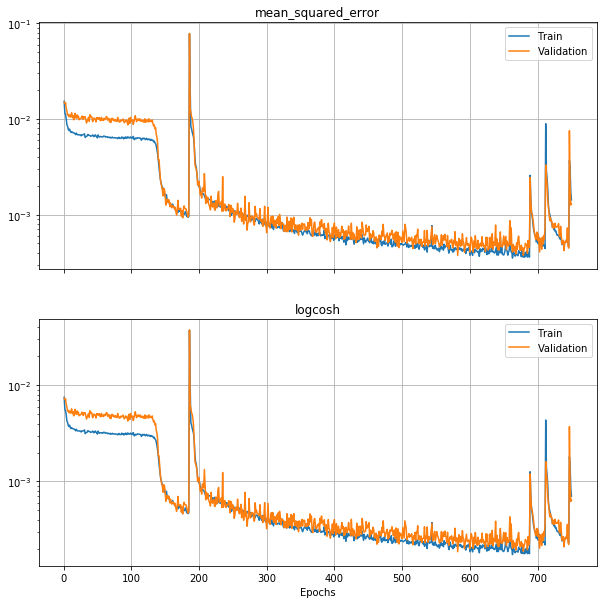

147/147 [==============================] - 40s 274ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - logcosh: 7.0383e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_logcosh: 6.4019e-04
Wall time: 8h 44min 37s


In [84]:
%%time
EPOCHS = 750
#se usa el repeat para llamar al generador mas de una vez
#steps_per_epoch  = numero de batches de los datos para determinar una epoca terminada 
#Por defecto -> number of samples in your dataset divided by the batch size (LEN_DT//BATCH_SIZE_TRAIN)
#verbose = mostrar el avance del entrenamiento
#validation_steps = numero de batches de datos para validar en cada epoca
#workers?
#max_queue_size?
history = model.fit(dataset_train.repeat(), 
                    epochs=EPOCHS, 
                    steps_per_epoch = len(X_train),
                    callbacks=callbacks, 
                    verbose=1,
                    validation_data = dataset_val.repeat(),
                    validation_steps= len(X_val))

#### Se guarda el Modelo

In [85]:
I = '2'
file_name = f'../Models/{dataset_name}_{I}_{window}.h5'
model.save(file_name)
print(file_name)

../Models/DatasetXYZYaw_2022V2_2_64.h5


### Evaluación del Modelo

#### Se carga el modelo

In [86]:
model = tf.keras.models.load_model(file_name)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64, 192)           166656    
_________________________________________________________________
lstm_7 (LSTM)                (None, 64, 256)           459776    
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dense_12 (Dense)             (None, 320)               20800     
_________________________________________________________________
dense_13 (Dense)             (None, 192)               61632     
_________________________________________________________________
dense_14 (Dense)             (None, 480)               92640     
_________________________________________________________________
dense_15 (Dense)             (None, 64)               

#### Evaluación con dataset de prueba

In [87]:
%%time
n_batches = np.ceil((len(X_test)*len(X_test[0])/N)/batch_size)
losses = model.evaluate(dataset_test, steps = n_batches)
K = df_desc[rpm_list[0]]["max"]-df_desc[rpm_list[0]]["min"] #Ganancia del actuador
print(f'K={"{:.2f}".format(K)}')
if not type(metrics) == list:
    metrics = [metrics]
for i, l in enumerate(['loss']+metrics):
    print(f'{l}: {"{:.2e}".format(losses[i])} -> {"{:.2e}".format(losses[i]*K)} RPM')

1/1 [==============================] - 1s 864ms/step - loss: 6.3095e-04 - mean_squared_error: 6.3095e-04 - logcosh: 3.1162e-04
K=490.00
loss: 6.31e-04 -> 3.09e-01 RPM
mean_squared_error: 6.31e-04 -> 3.09e-01 RPM
logcosh: 3.12e-04 -> 1.53e-01 RPM
Wall time: 986 ms


#### Evaluación con 1 trayectoria

In [88]:
window_test = 3000
test_traj_generator  = DataGenerator(X=X_test,  Y=Y_test,  batch_size=1, window=window_test, sequence_out=True)

In [89]:
%%time
X, Y = next(test_traj_generator.build_data())
x = X[0]
y = Y[0]
y = y[window:]
y_pred = []
for i in range(window, len(x)):
    x_temp = x[i-window:i].reshape(1,  window, X.shape[2])
    y_temp = model.predict(x_temp)
    y_pred.append(y_temp)
y_pred = np.array(y_pred).reshape(y.shape)

Wall time: 3min 46s


#### Visualización con 1 trayectoria

In [90]:
t = np.arange(0, len(y)*Ts, Ts)

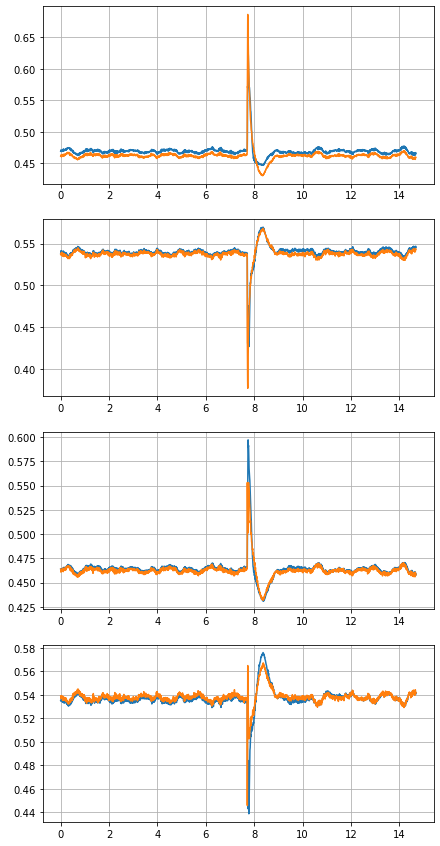

In [91]:
fig, axs = plt.subplots(Y.shape[2], figsize = (7,15))
for i in range(Y.shape[2]):
    axs[i].plot(t, y_pred[:,i], t, y[:,i])
    axs[i].grid()

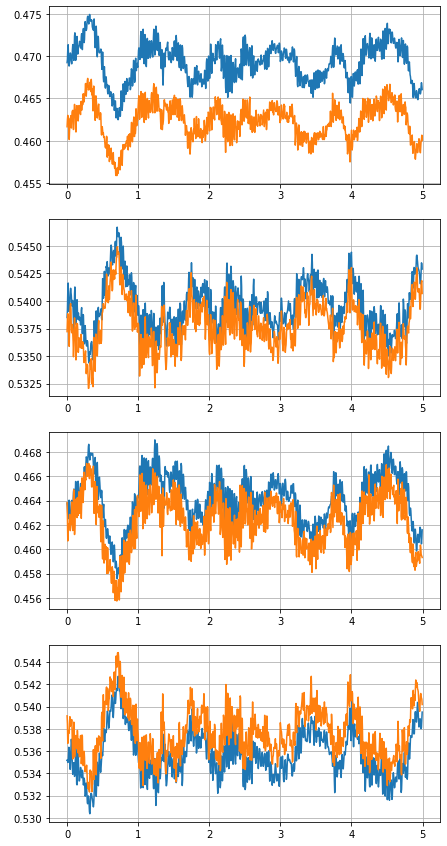

In [92]:
fig, axs = plt.subplots(Y.shape[2], figsize = (7,15))
for i in range(Y.shape[2]):
    axs[i].plot(t[0:1000], y_pred[0:1000,i], t[0:1000], y[0:1000,i])
    axs[i].grid()

#### Tiempo de inferencia tamaño entrada

In [43]:
import time

def MSE(y, y_pred):
    return (y-y_pred)**2

window_test = 1000
test_traj_batch = 8192 
test_traj_generator  = DataGenerator(X=X_test,  Y=Y_test,  batch_size=test_traj_batch, window=window_test, sequence_out=True)

window_len = []
inf_time = []
loss = []

x, y = next(test_traj_generator.build_data())

In [44]:
%%time
accum_time = 0
n_iter = 100
#set -> conjunto de datos distribuidos de forma random
#np.log10 -> logaritmo en base 10 de un array
#np.logspace -> genera un rango de valores entre 0 y el tamaño de la ventana, con muestras de n_iter
#np.rint -> aproxima los numeros al entero mas cercano
# Se genera una distribucion de datos con espaciado logaritmico y aleatoria de tamaño n_iter
test_range = list(set(np.rint(np.logspace(0, np.log10(x.shape[1]-1), num=n_iter, endpoint=True))))
#ordena la lista de menor a mayor
test_range.sort()
n_iter = len(test_range)
#map -> mapea cada elemento y lo convierte a entero
for k, i in enumerate(list(map(int,test_range))):
    inf_time_aux = []    # Tiempo de inferencia auxiliar
    loss_aux = []    # Costo Auxiliar
    init_time = time.time()
    #se barre todo el batch
    for j in range(len(x)):
        #se toma una muestra del batch
        x_5 = x[j][0:i].reshape(1,  i, x.shape[2])
        start_time = time.time()
        y_pred = model.predict(x_5)
        finish_time = time.time() - start_time
        inf_time_aux.append(finish_time)
        loss_aux.append(
            np.mean(
                MSE(y[j][i], y_pred)
            )
        )
    #Se guarda el tamaño de ventana, el tiempo y la perdida
    window_len.append(i)
    inf_time.append(np.mean(inf_time_aux))
    loss.append(np.mean(loss_aux))
    #Se limpia la salida impresa en pantalla
    clear_output(wait=True)
    #se guarda el tiempo total de ejecucion
    accum_time += time.time()-init_time
    print(f'iter = {k} de {test_range}, i = {i}, execution time = {"{:.2f}".format(np.max(accum_time))}s')

ValueError: Error when checking input: expected lstm_input to have shape (64, 24) but got array with shape (1, 24)

In [45]:
inf_time_norm = np.array(inf_time)/max(inf_time)
loss_norm = np.array(loss)/max(loss)
performance = 1/(np.array(loss)*np.array(inf_time))
performance = np.array(performance)/max(performance)

ValueError: max() arg is an empty sequence

In [ ]:
plt.figure()
plt.plot(window_len, inf_time_norm, label='Normalized inference time', alpha=0.7)
plt.plot(window_len, loss_norm, label='Normalized average MSE', alpha=0.7)
plt.plot(window_len, performance, label='Performance=1/(MSE*Time)', alpha=0.7)
plt.xlabel("Window Size")
plt.legend(loc=1)
plt.grid()

print(f'Best window inference time={np.argmin(inf_time_norm)} steps, time={"{:.2f}".format(np.min(inf_time)*1000)} ms')
print(f'Best window MSE loss={np.argmin(loss_norm)} steps, MSE={"{:.2e}".format(np.min(loss))}')
print(f'Best window Performance (MSExTime)={np.argmax(performance)} steps, Value={"{:.2e}".format(np.max(loss)/np.min(inf_time))}')

In [ ]:
plt.figure()
plt.semilogx(window_len, inf_time_norm, label='Normalized inference time', alpha=0.7)
plt.semilogx(window_len, loss_norm, label='Normalized average MSE', alpha=0.7)
plt.semilogx(window_len, performance, label='Performance=1/(MSE*Time)', alpha=0.7)
plt.xlabel("Window Size")
plt.legend(loc=1)
plt.grid()

In [ ]:
session.close()